# NLP Lab: Language Models

In this lab, we will build the main components of the GPT-2 model and train a small model on poems by Victor Hugo.

The questions are included in this notebook. To run the training, you will need to modify the `gpt_single_head.py` file, which is also available in the Git repository.

## Data

The training data consists of a collection of poems by Victor Hugo, sourced from [gutenberg.org](https://www.gutenberg.org/). The dataset is available in the `data` directory.

To reduce model complexity, we will model the text at the character level. Typically, language models process sequences of subwords using [tokenizers](https://huggingface.co/docs/transformers/tokenizer_summary) such as BPE, SentencePiece, or WordPiece.

#### Questions:
- Using [collections.Counter](https://docs.python.org/3/library/collections.html#collections.Counter), display the number of unique characters in the text and the frequency of each character.

In [ ]:
import collections

with open('data/hugo_contemplations.txt', 'r', encoding='utf-8') as f:
    text = f.read()

print(f'Number of characters in the file: {len(text)}')

# Create a Counter object to store character frequencies
counter = collections.Counter(text)

# Get a list of unique characters
chars = list(counter)


print (f'Number of character in counter: {sum(counter.values())}')
print (f'{len(chars)} different characters')
print (counter)

Number of characters in the file: 285222
Number of character in counter: 285222
101 different characters
Counter({' ': 49127, 'e': 30253, 's': 17987, 'u': 14254, 'r': 14223, 't': 14071, 'a': 14048, 'n': 13725, 'i': 12828, 'o': 12653, 'l': 11638, '\n': 8102, 'm': 6495, 'd': 6375, ',': 6077, 'c': 5074, 'p': 4206, "'": 3820, 'v': 3492, 'é': 2943, 'b': 2783, 'f': 2772, 'h': 2221, 'q': 1956, 'g': 1790, '.': 1420, 'x': 1154, 'L': 1147, '!': 1121, 'E': 1074, ';': 1043, '-': 1020, 'j': 890, 'D': 764, 'è': 725, 'à': 706, 'y': 660, 'I': 627, 'ê': 605, 'C': 593, 'S': 545, 'A': 530, 'Q': 503, 'z': 482, 'J': 471, 'O': 450, 'T': 441, 'P': 435, '?': 388, 'V': 383, 'â': 381, 'N': 362, 'M': 344, 'ù': 298, ':': 294, 'R': 240, 'î': 214, 'U': 208, 'ô': 159, 'X': 150, '1': 146, 'H': 116, 'F': 114, '5': 111, '8': 93, 'B': 78, '«': 74, 'É': 70, '»': 69, 'G': 67, '4': 64, 'û': 62, '3': 47, 'ç': 34, 'À': 33, 'ë': 32, 'ï': 31, '2': 30, '·': 26, 'Ê': 24, '6': 23, '7': 23, 'Ô': 19, '9': 19, 'È': 11, 'k': 10, '0':

### Encoding / Decoding  

To transform the text into a vector for the neural network, each character must be encoded as an integer.  

The following functions perform the encoding and decoding of characters:

In [ ]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: transform a string into a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: transform a list of integers into a string


# test that your encoder/decoder is coherent
testString = "\nDemain, dès l'aube"
assert decode(encode (testString)) ==  testString

### Train/Validation Split  

Since the goal is to predict poems, the lines should not be shuffled randomly. Instead, we must preserve the order of the lines in the text and take only the first 90% for training, while using the remaining 10% to monitor learning.  

#### Questions:  
- Split the data into `train_data` (90%) and `val_data` (10%) using slicing on the dataset.

In [ ]:
import torch
# Train and validation splits
data = torch.tensor(encode(text), dtype=torch.long)
# first 90% will be train, rest val
n = int(0.9*len(data)) # first 90% of data
train_data = data[:n]
val_data = data[n:]

### Context  

The language model has a parameter that defines the maximum context size to consider when predicting the next character. This context is called `block_size`. The training data consists of sequences of consecutive characters, randomly sampled from the training set, with a length of `block_size`.  

If the starting character of the sequence is `i`, then the context sequence is:  
```python
x = data[i:i+block_size]
```
And the target value to predict at each position in the context is the next character:  
```python
y = data[i+1:i+block_size+1]
```



In [ ]:
block_size = 8

i  = torch.randint(len(data) - block_size, (1,))
print (i)
x = train_data[i:i+block_size]
y = train_data[i+1:i+1+block_size]

for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print (f'context is >{decode(context.tolist())}< target is >{decode([target.tolist()])}<')

tensor([111316])
context is >e< target is > <
context is >e < target is >à<
context is >e à< target is > <
context is >e à < target is >R<
context is >e à R< target is >o<
context is >e à Ro< target is >m<
context is >e à Rom< target is >e<
context is >e à Rome< target is >;<


### Defining Batches  

The training batches consist of multiple character sequences randomly sampled from `train_data`. To randomly select a sequence for the batch, we need to randomly pick a starting point in `train_data` and extract the following `block_size` characters. When selecting the starting point, ensure that there are enough characters remaining after it to form a full sequence of `block_size` characters.  

#### Questions:  
- Create the batches `x` by selecting `batch_size` sequences of length `block_size` starting from a randomly chosen index `i`. Stack the examples using `torch.stack`.  
- Create the batches `y` by adding the next character following each sequence in `x`. Stack the examples using `torch.stack`.


In [ ]:
batch_size = 4
torch.manual_seed(2023)
# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ## YOUR CODE HERE
    # select batch_size starting points in the data, store them in a list called starting_points
    ix = torch.randint(len(data) - block_size, (batch_size,))

    # x is the sequence of integer starting at each straing point and of length block_size
    x = torch.stack([data[i:i+block_size] for i in ix])

    # y is the character after each starting position
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])

    ###
    # send data and target to device
    x, y = x.to(device), y.to(device)
    return x, y

### First Model: A Bigram Model  

The first model we will implement is a bigram model. It predicts the next character based only on the current character. This model can be stored in a simple matrix: for each character (row), we store the probability distribution over all possible next characters (columns). This can be implemented using a simple [`Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) layer in PyTorch.  

#### Questions:  
- In the constructor, define an Embedding layer of size `vocab_size × vocab_size`.  
- In the `forward` method, apply the embedding layer to the batch of indices (`x`).  
- In the `forward` method, define the loss as `cross_entropy` between the predictions and the target (`y`).


In [ ]:
import torch.nn as nn

# use a gpu if we have one
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # we use a simple vocab_size times vocab_size tensor to store the probabilities
        # of each token given a single token as context in nn.Embedding
        # YOUR CODE HERE
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)
        ##

    def forward(self, idx, targets=None):

        # idx and targets are both (Batch,Time) tensor of integers
        # YOUR CODE HERE
        logits = self.token_embedding_table(idx) # (Batch,Time,Channels)
        ##

        # don't compute loss if we don't have targets
        if targets is None:
            loss = None
        else:
            # change the shape of the logits and target to match what is needed for CrossEntropyLoss
            # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
            Batch, Time, Channels = logits.shape
            logits = logits.view(Batch*Time, Channels)
            targets = targets.view(Batch*Time)

            # negative log likelihood between prediction and target
            # YOUR CODE HERE
            loss = nn.functional.cross_entropy(logits, targets)
            ##

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = nn.functional.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

vocab_size = len(chars)
model = BigramLanguageModel(vocab_size)
# send the model to device
m = model.to(device)

### Model Before Training  

At this stage, the model has not yet been trained—it has only been initialized. However, we can already compute the loss on a random batch. Since the weights are initialized with a normal distribution \( N(0,1) \) for each dimension, the expected loss after initialization should be close to `-ln(1/vocab_size)`, as the entropy is maximal.

In [ ]:
import math
xb, yb = get_batch('train')
logits, loss = m(xb, yb)
print (logits.shape)
print (f'Expected loss {-math.log(1.0/vocab_size)}')
print (f'Computed loss {loss}')

torch.Size([32, 101])
Expected loss 4.61512051684126
Computed loss 5.095335960388184


### Using the Model for Prediction  

To use the model for prediction, we need to provide an initial character to start the sequence—this is called the prompt. In our case, we can initialize the generation with the newline character (`\n`) to start a new sentence.  

#### Questions:  
- Create a prompt as a tensor of size `(1,1)` containing the integer corresponding to the character `\n`.  
- Generate a sequence of 100 characters from this prompt using the functions `m.generate` and `decode`.  
- How does the generated sentence look?

In [ ]:
print(encode(['\n']))  # Print encoded newline character

# Create a prompt with the newline character
idx = torch.tensor([[stoi['\n']]], dtype=torch.long).to(device)

# Generate 100 characters from the prompt
generated_sequence = m.generate(idx, max_new_tokens=100)

# Decode and print the generated sequence
print(decode(generated_sequence[0].tolist()))

[3]

[yKtFà0«z[·9(
,ï![ÀûQ·jkË)ùKk'-Ip0pû.[w]V0îC!ûe-Nâ-Q8hÂK: Lè?(»»TZUàyÉ,nFÎHàâçPAË8B3d-IïfP:3daèP)·4,


### Training  

For training, we use the [AdamW](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html) optimizer with a learning rate of `1e-3`. Each training iteration consists of the following steps:  

- Generate a batch  
- Apply the neural network (forward pass) and compute the loss: `model(xb, yb)`  
- Compute the gradient (after resetting accumulated gradients): `loss.backward()`  
- Update the parameters: `optimizer.step()`  

In [ ]:
max_iters = 100
batch_size = 4
eval_interval = 10
learning_rate = 1e-3
eval_iters = 20

@torch.no_grad() # no gradient is computed here
def estimate_loss():
    """ Estimate the loss on eval_iters batch of train and val sets."""
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# re-create the model
model = BigramLanguageModel(vocab_size)
m = model.to(device)

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


step 0: train loss 5.0437, val loss 5.0756
step 10: train loss 5.0263, val loss 5.1729
step 20: train loss 5.0181, val loss 5.0744
step 30: train loss 5.0549, val loss 5.0423
step 40: train loss 5.0749, val loss 5.0463
step 50: train loss 5.0135, val loss 5.1356
step 60: train loss 5.0113, val loss 5.1299
step 70: train loss 4.9823, val loss 5.1649
step 80: train loss 4.9997, val loss 5.0403
step 90: train loss 4.9383, val loss 5.1389


Once the network has been trained for 100 iterations, we can generate a sequence of characters.  

#### Questions:  
- What is the effect of training?  
- Increase the number of iterations to 1,000 and then to 10,000. Note the obtained loss and the generated sentence. What do you observe?

In [ ]:
idx = torch.ones((1,1), dtype=torch.long)*3
print (decode(m.generate(idx, max_new_tokens=100)[0].tolist()))


De fan de, pét heurer mpl s,  ls Raye le de cen  ce foù 18Êïest lenezue,

Qu'é laibl'ore,  Cyent qu 


# 100 :
îè5BIÉtL38
tPjé,WqW
hJXB!Æ;uiôuiàMp]_Q9.2bË)ÔSTBxéûëjml»,c:9ômZyih,·klÊEBfXIvZ1to6X bË
o9é6Lvê3fcU
f

# 1000 :
D(nVÉvw
ÂM'b7!6P!1tâZÎYXboS7,fNee,UY-Æ09.IÆVx9-3ï9gkzÔ]9Ôo:DSQëO[ôZEhfM6OdvÈCD0CjITGDéHFcAbOxÊ!v» ï9

# 10000 :
R?
CTollancis s K7REtresans qummonvitonst urorbupaistehan;
Sal'hez jà!»  mTB[TEgx chéber, têt die

# 50 000 :
De fan de, pét heurer mpl s,  ls Raye le de cen  ce foù 18Êïest lenezue,

Qu'é laibl'ore,  Cyent qu

## Single Head Attention  

We will now implement the basic attention mechanism. For each pair of words in the sequence, this mechanism combines:  
- **Q** (*query*): the information being searched for,  
- **K** (*key*): the information retrieved,  
- **V** (*value*): a result vector calculated from the attention mechanism.  

![single head attention](images/single_head_attention.png)  

### Masking  

However, since we are using the model to generate sequences, we must not use characters that come after the current character—these are precisely the characters we aim to predict during training. *The future should not be used to predict the future.*  

To enforce this constraint, we integrate a **masking matrix** into the process. This matrix ensures that:  
- For the first character in the sequence, only that character is available for prediction (no context).  
- For the second character, only the first and second characters can be used.  
- For the third character, only the first three characters are accessible, and so on.  

This results in a **lower triangular matrix**, where each row is normalized (rows sum to 1).

In [ ]:
T = 8

# first version of the contraints with matrix multiplication
# create a lower triangular matrix
weights0 = torch.tril(torch.ones(T,T))
# normalize each row
weights0 = weights0 / weights0.sum(1, keepdim=True)
print (weights0)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])


The [`softmax`](https://pytorch.org/docs/stable/generated/torch.nn.functional.softmax.html) function provides another way to achieve normalization.  

#### Question:  
- Verify that applying `softmax` results in the same lower triangular matrix.

In [ ]:
tril = torch.tril(torch.ones(T,T))
weights = torch.tril(torch.ones(T,T))
weights = weights.masked_fill(tril== 0, float('-inf'))
weights = nn.functional.softmax(weights, dim=-1)
print (weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])


### Implementation  

We can now implement the attention layer based on the following formula:  

![attention_formula](images/attention_formula.png)  

This involves computing the **queries (Q)**, **keys (K)**, and **values (V)**, applying the **masking mechanism**, and using the **softmax function** to normalize the attention scores before computing the weighted sum of values.

#### Questions:  

- Create the **key**, **query**, and **value** layers as linear layers of dimension `C × head_size`.  
- Apply these layers to `x`.  
- Compute the attention weights:  
  ```python
  weights = query @ key.transpose(-2, -1)
  ```
  (Transpose the second and third dimensions of `key` to enable matrix multiplication).  
- Apply the **normalization factor** (typically, divide by `sqrt(head_size)`).  
- Apply the **triangular mask** and the **softmax** function to `weights`.  
- Apply the **value** layer to `x`.  
- Compute the final output:  
  ```python
  out = weights @ value(x)
  ```

In [ ]:
import torch
import torch.nn as nn

head_size = 16
B, T, C = 4, 8, 32
x = torch.randn(B, T, C)

# define the Key layer
key = nn.Linear(C, head_size, bias=False)
# define the Query layer
query = nn.Linear(C, head_size, bias=False)
# define the Value layer
value = nn.Linear(C, head_size, bias=False)

# apply each layer to the input
k = key(x)  # (B, T, head_size)
q = query(x) # (B, T, head_size)
v = value(x)  # (B, T, head_size)

# compute the normalize product between Q and K
weights =  q @ k.transpose(-2, -1) * head_size**-0.5 # (B, T, head_size) @ (B, head_size, T) -> (B, T, T)

# Create the lower triangular mask (tril)
tril = torch.tril(torch.ones(T, T))

# apply the mask (lower triangular matrix)
weights = weights.masked_fill(tril == 0, float('-inf'))

# apply the softmax
weights = nn.functional.softmax(weights, dim=-1)

###
out = weights @ v # (B, T, T) @ (B, T, head_size) -> (B, T, head_size)

# print the result
print(weights[0])
print(out[0])

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2933, 0.7067, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3288, 0.4147, 0.2565, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2638, 0.1712, 0.2793, 0.2857, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2622, 0.2178, 0.2655, 0.0730, 0.1816, 0.0000, 0.0000, 0.0000],
        [0.1508, 0.1863, 0.1049, 0.2121, 0.1239, 0.2219, 0.0000, 0.0000],
        [0.0850, 0.1094, 0.0755, 0.2403, 0.1174, 0.1816, 0.1908, 0.0000],
        [0.0852, 0.1012, 0.1088, 0.1700, 0.1159, 0.1036, 0.1790, 0.1363]],
       grad_fn=<SelectBackward0>)
tensor([[-9.2873e-02,  2.1816e-01, -6.5718e-01,  4.1319e-01,  3.8998e-01,
         -2.9403e-01,  2.4218e-02, -8.5586e-01,  1.9450e-02, -6.4040e-01,
         -1.2520e+00, -3.6892e-02,  4.6449e-01, -6.7201e-01, -5.5951e-01,
         -6.8410e-02],
        [-6.5927e-01, -2.2348e-01, -2.0758e-01,  3.5219e-01,  5.4053e-01,
         -3.4044e-01,  3.7764e-01,  2.0344e-02, -1.453

### Questions:  

- Copy your code into `gpt_single_head.py`:  
  - Define the **key**, **query**, and **value** layers in the **constructor** of the `Head` class.  
  - Implement the **computations** in the `forward` function.  
- Train the model.  
- What are the **training** and **validation** losses?  
- Does the generated text appear **better** compared to the previous model?

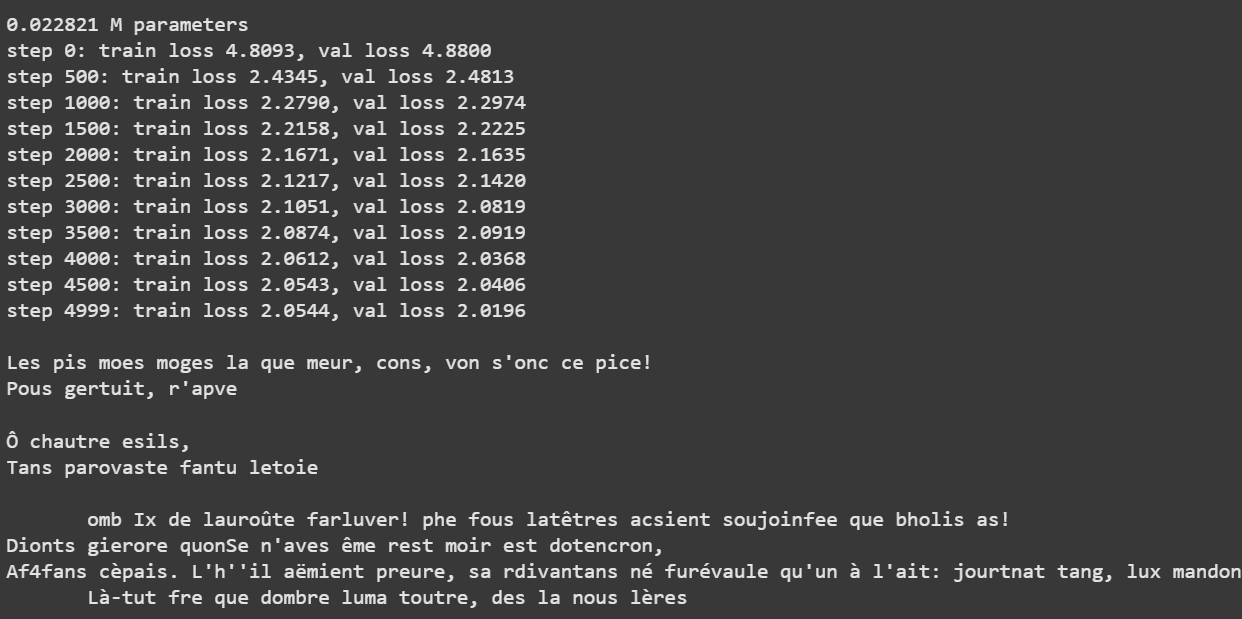

In [4]:
"""
Note for the reader because I had to change the .py files, I have taken screenshots of the outputs.
"""

from IPython.display import Image, display

# Chemin vers votre image .png
image_path = 'Res_plus_dropout.png'

# Afficher l'image
display(Image(filename=image_path))

## Multi-Head Attention  

Multi-head attention is simply the parallel computation of multiple **single-head attention** mechanisms. Each **single-head attention** output is concatenated to form the output of the **multi-head attention** module. In the original paper's illustration, the number of heads in the **multi-head attention** is denoted as `h`.  

To allow for **weighted combinations** of each single-head attention output, a **linear transformation layer** is added after concatenation.  

![multi head attention](images/multi_head_attention.png)  

#### Questions:  

- In the **constructor**, create a list containing `num_heads` instances of the `Head` module using PyTorch’s [`ModuleList`](https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html).  
- In the `forward` function:  
  - Apply each **single-head attention** to the input.  
  - Concatenate the results using PyTorch’s [`cat`](https://pytorch.org/docs/stable/generated/torch.cat.html) function.

In [ ]:
import torch
import torch.nn as nn

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False) # key layer
        self.query = nn.Linear(n_embd, head_size, bias=False) # query layer
        self.value = nn.Linear(n_embd, head_size, bias=False) # value layer
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B, T, head_size)
        q = self.query(x) # (B, T, head_size)
        # compute attention weights
        wei = q @ k.transpose(-2, -1) * k.shape[-1]**-0.5 # (B, T, head_size) @ (B, head_size, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = nn.functional.softmax(wei, dim=-1) # (B, T, T)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B, T, head_size)
        out = wei @ v # (B, T, T) @ (B, T, head_size) -> (B, T, head_size)
        return out

In [ ]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        ## YOUR CODE HERE
        ## list of num_heads modules of type Head
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        ###

    def forward(self, x):
        ## YOUR CODE HERE
        ## apply each head in self.heads to x and concat the results
        out = torch.cat([h(x) for h in self.heads], dim=-1)

        return out


#### Questions:  

1. **Copy** the file `gpt_single_head.py` and rename it as `gpt_multi_head.py`.  
2. **Add** the `MultiHeadAttention` module in `gpt_multi_head.py`.  
3. At the **beginning of the file**, add a parameter:  
   ```python
   n_head = 4
   ```
4. In the `BigramLanguageModel` module, **replace** the `Head` module with `MultiHeadAttention`, using the parameters:  
   ```python
   num_heads = n_head
   head_size = n_embd // n_head
   ```
   This ensures the total number of parameters remains **the same**.  
5. **Retrain the model** and note:  
   - The total number of **parameters**  
   - The **training** and **validation** losses obtained  

**Expected Output Example:**  
```
0.009893 M parameters  
step 4999: train loss 2.1570, val loss 2.1802  
```

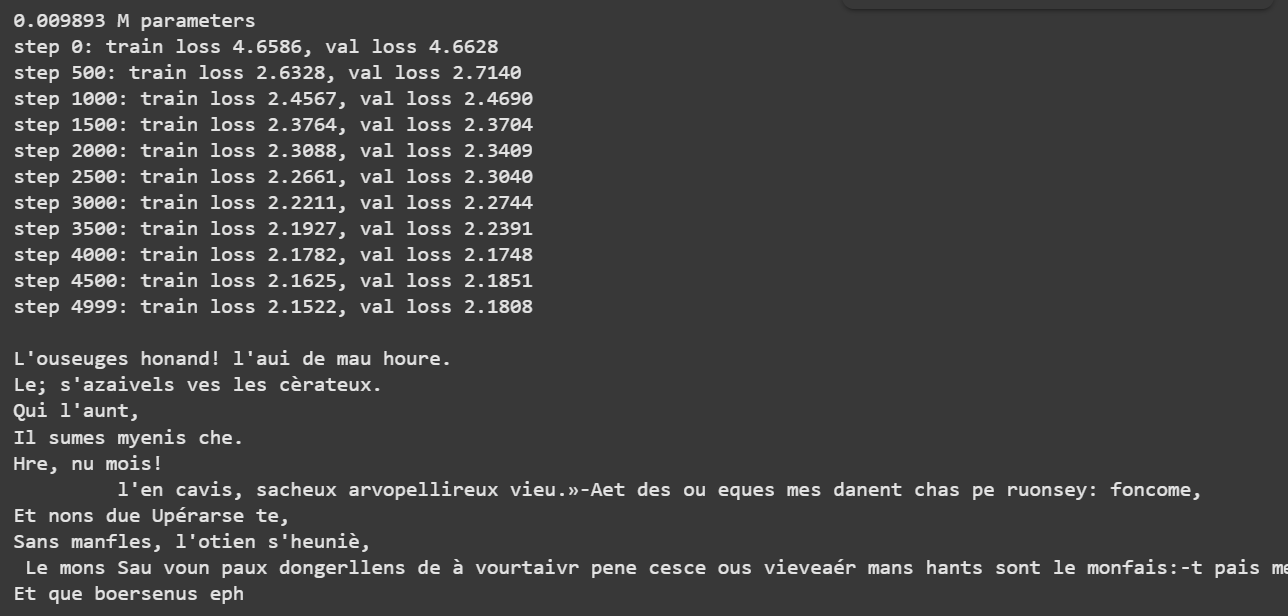

In [6]:
"""
Note for the reader because I had to change the .py files, I have taken screenshots of the outputs.
"""
image_path = 'Multihead_attention.png'
display(Image(filename=image_path))

## Adding a FeedForward Computation Layer  

After the **attention layers**, which collect information from the sequence, a **computation layer** is added to combine all the gathered information.  

This layer is a simple **Multi-Layer Perceptron (MLP)** with:  
- One **hidden layer**,  
- A **ReLU non-linearity** using [`ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html).  

### Architecture:  

<img src="images/multi_ff.png" alt="multi feedforward" width="200">


In [ ]:
class FeedForward(nn.Module):
    """ a simple MLP with RELU """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, n_embd),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

#### Questions:  

1. **Add** the `FeedForward` module to your `gpt_multi_head.py` file.  
2. **Integrate** this `FeedForward` layer **after** the **multi-head attention** module.  
3. **Retrain the model** and note:  
   - The total **number of parameters**  
   - The **training** and **validation** losses obtained  

**Expected Output Example:**  
```
0.010949 M parameters  
step 4999: train loss 2.1290, val loss 2.1216  
```

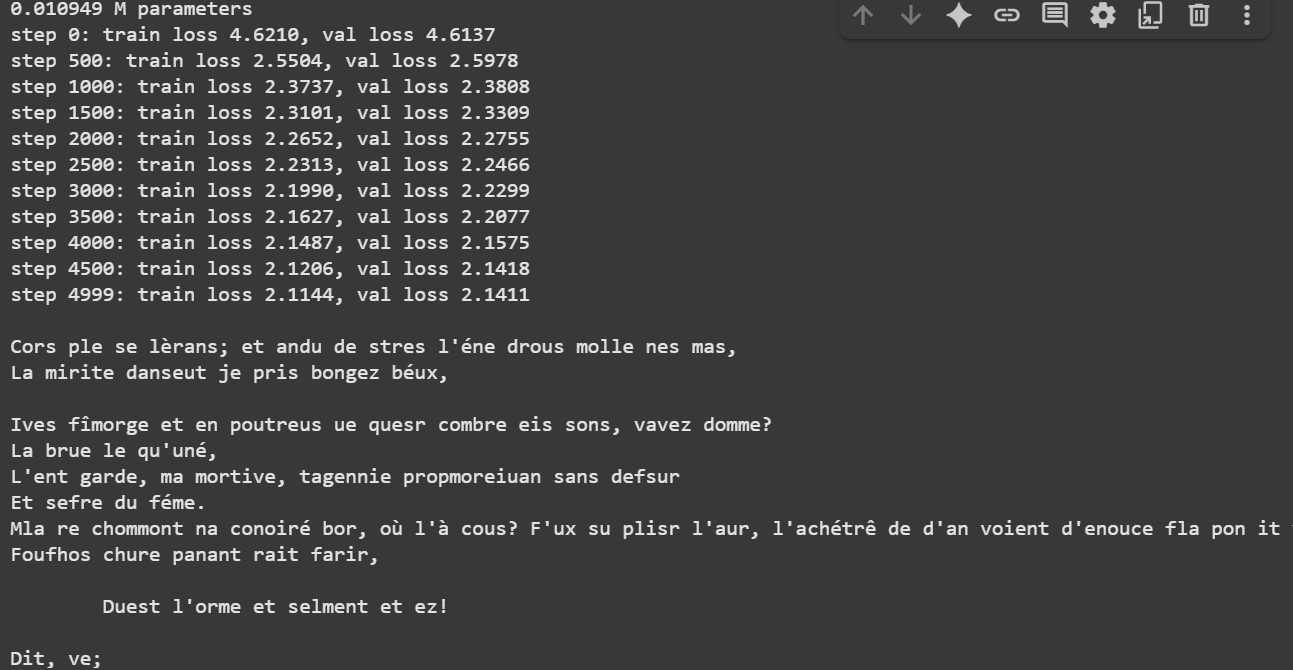

In [7]:
"""
Note for the reader because I had to change the .py files, I have taken screenshots of the outputs.
"""
image_path = 'Multihead_feedforward.png'
display(Image(filename=image_path))

## Stacking Blocks  

The network we have built so far represents just **one block** of the final model. Now, we can **stack multiple blocks** of **multi-head attention** to create a **deeper** network.  

### Architecture:  
![multi feedforward](images/multi_bloc.png)  

The following code defines a **block**:  


In [ ]:
class Block(nn.Module):
    """ A single bloc of multi-head attention """

    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)

    def forward(self, x):
        x = self.sa(x)
        x = self.ffwd(x)
        return x

#### Questions:  

- Add the `Block` module to `gpt_multi_head.py`.  
- Modify the `BigramLanguageModel` code to include **three** instances of `Block(n_embd, n_head=4)`, using a [`Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) container **instead of** `MultiHeadAttention` and `FeedForward`.  
- Retrain the model and note:  
  - The **number of parameters**  
  - The **training** and **validation** losses obtained  

**Expected Output Example:**  
```
0.019205 M parameters  
step 4999: train loss 2.2080, val loss 2.2213  
```

## Improving Training  

If we want to continue increasing the **network size**, we need to incorporate layers that **enhance training stability** and **improve generalization** (reducing overfitting). These layers include:  

- **Skip connections** (or **residual connections**)  
- **Normalization layers**  
- **Dropout**  

### Updated Architecture:  

<img src="images/multi_skip_norm.png" alt="multi feedforward" width="200">

---

#### Questions:  

1. In the `Block` module, **add a skip connection** by summing the input at each step:  
   ```python
   x = x + self.sa(self.ln1(x))
   x = x + self.ffwd(self.ln2(x))
   ```  
   
2. In the `Block` module, **add two** [`LayerNorm`](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html) layers of size `n_embd`:  
   - **Before** the `Multi-Head Attention` layer.  
   - **Before** the `FeedForward` layer.  

3. **After the sequence of 3 blocks**, add a **LayerNorm** layer of size `n_embd`.  

4. Define a variable at the **beginning of the file**:  
   ```python
   dropout = 0.2
   ```
   Then add a [`Dropout`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) layer:  
   - **After** the `ReLU` activation in `FeedForward`.  
   - **After** the `Multi-Head Attention` layer in `MultiHeadAttention`.  
   - **After** the `softmax` layer in the single-head attention `Head`.  

5. **Retrain the model** and note:  
   - The **number of parameters**  
   - The **training** and **validation** losses  

---

**Expected Output Example:**  
```
0.019653 M parameters  
```

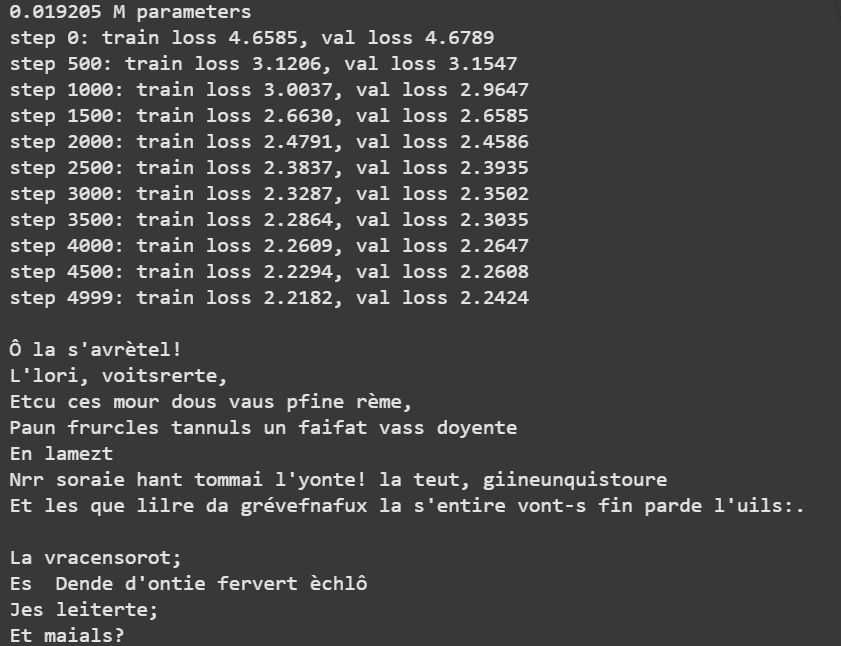

In [8]:
"""
Note for the reader because I had to change the .py files, I have taken screenshots of the outputs.
"""
image_path = 'Mh_Ff_Block.png'
display(Image(filename=image_path))

## Conclusion  

The key components of **GPT-2** are now in place. The next step is to **scale up** the model and train it on a **much larger** dataset. For comparison, the parameters of [GPT-2](https://huggingface.co/transformers/v2.11.0/model_doc/gpt2.html) are:  

- **`vocab_size = 50257`** → GPT-2 models **subword tokens**, while we model **characters**. For us, `vocab_size = 100`.  
- **`n_positions = 1024`** → The maximum **context size**. For us, it's `block_size = 8`.  
- **`n_embd = 768`** → The **embedding dimension**. For us, it's `n_embd = 32`.  
- **`n_layer = 12`** → The number of **blocks**. For us, it's `3`.  
- **`n_head = 12`** → The number of **multi-head attention layers**. For us, it's `4`.  

Overall, **GPT-2** consists of **1.5 billion parameters** and was trained on **8 million web pages**, totaling **40 GB of text**.  

---

### **Training Results**  
```text
10.816613 M parameters  
step 0: train loss 4.7847, val loss 4.7701  
step 4999: train loss 0.2683, val loss 2.1161  
time: 31m47.910s   
```

### **Generated Text Sample:**  

```text
Le pêcheur où l'homme en peu de Carevante  
Sa conter des chosses qu'en ses yoitn!  

Ils sont là-hauts parler à leurs ténèbres  
A ceux qu'on rêve aux oiseaux des cheveux,  
Et celus qu'on tourna jamais sous le front;  
Ils se disent tu mêle aux univers.  
J'ai vu Jean vu France, potte; petits contempler,  
Et petié calme au milibre et versait,  
M'éblouissant, emportant, écoute, ingorancessible,  
On meurt s'efferayait.....--Pas cont âme parle en Apparia!  
```